In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Import Imputeed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Imputed.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold'
]]
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype(str)

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [4]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder_nominal = OneHotEncoder(drop='first', sparse_output=False)
encoder_ordinal = OneHotEncoder(drop='first', sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

# --- One-Hot Encode Nominal ---
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [5]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

Best parameters: {'criterion': 'squared_error', 'max_depth': 25}
Best CV accuracy: 0.7893


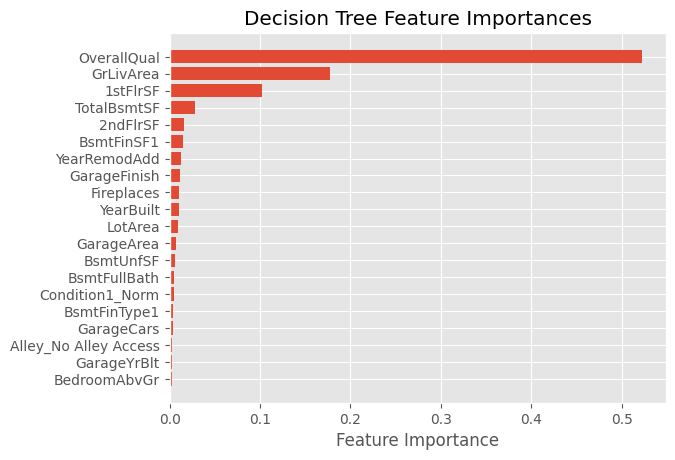

OverallQual: 0.5225
GrLivArea: 0.1771
1stFlrSF: 0.1018
TotalBsmtSF: 0.0282
2ndFlrSF: 0.0161
BsmtFinSF1: 0.0153
YearRemodAdd: 0.0126
GarageFinish: 0.0112
Fireplaces: 0.0104
YearBuilt: 0.0103
LotArea: 0.0090
GarageArea: 0.0066
BsmtUnfSF: 0.0060
BsmtFullBath: 0.0051
Condition1_Norm: 0.0046
BsmtFinType1: 0.0036
GarageCars: 0.0034
Alley_No Alley Access: 0.0027
GarageYrBlt: 0.0026
BedroomAbvGr: 0.0026
MoSold: 0.0025
BsmtQual: 0.0025
MSZoning_RL: 0.0023
MSZoning_RM: 0.0023
MasVnrArea: 0.0022
LotFrontage: 0.0020
BsmtExposure: 0.0020
GarageCond: 0.0019
OpenPorchSF: 0.0018
SaleType_WD : 0.0016
OverallCond: 0.0013
FireplaceQu: 0.0013
Neighborhood_ClearCr: 0.0012
HalfBath: 0.0012
KitchenQual: 0.0011
LotShape: 0.0010
TotRmsAbvGrd: 0.0009
SaleCondition_Family: 0.0009
LandSlope: 0.0009
Neighborhood_NAmes: 0.0008
YrSold: 0.0008
EnclosedPorch: 0.0008
Neighborhood_Crawfor: 0.0007
WoodDeckSF: 0.0007
BsmtCond: 0.0007
LandContour_Lvl: 0.0006
Foundation_CBlock: 0.0006
Neighborhood_Gilbert: 0.0005
Electrical

In [6]:
#Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=2)

#Grid Search
grid_para_tree = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': range(1, 31)
}
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=grid_para_tree,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_tree.fit(X, Y)

print('Best parameters:', grid_search_tree.best_params_)
print('Best CV accuracy: %.4f' % grid_search_tree.best_score_)
best_tree = grid_search_tree.best_estimator_
importances = best_tree.feature_importances_

#Feature Name-Importance Pairs
feature_names = X.columns
feature_importance = list(zip(feature_names, importances))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

#Plot Top 20 Feature Importances
top_features = feature_importance_sorted[:20]
names, values = zip(*top_features)
plt.barh(names, values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.show()

#Print All Importances
for name, importance in feature_importance_sorted:
    print(f"{name}: {importance:.4f}")

In [ ]:
bag = cross_val_score(BaggingRegressor(random_state=2), X, Y, cv=5, scoring='r2')
bag.mean()

In [ ]:
base_tree = DecisionTreeRegressor(random_state=2)
bagging_model = BaggingRegressor(estimator=base_tree, random_state=2, n_jobs=-1)

In [29]:
#Initial Bagging RandomizedSearchCV for faster estimates
param_dist = {
    'estimator__criterion': ['squared_error', 'absolute_error'],
    'estimator__max_depth': [15, 16, 17],
    'n_estimators': [100, 101, 102]
}
random_search = RandomizedSearchCV(
    bagging_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search.fit(X, Y)
print('Best parameters:', random_search.best_params_)
print(f'Best CV Score: {random_search.best_score_:.4f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'n_estimators': 101, 'estimator__max_depth': 16, 'estimator__criterion': 'squared_error'}
Best CV Score: 0.8963


In [35]:
#Final Bagging Grid Search
grid_params_bagging = {
    'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'estimator__max_depth': [15, 16, 17],
    'n_estimators': [87, 88, 89]
}
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=grid_params_bagging,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_bagging.fit(X, Y)

print('Best parameters:', grid_search_bagging.best_params_)
print(f'Best CV R²: {grid_search_bagging.best_score_:.4f}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 16, 'n_estimators': 88}
Best CV R²: 0.8965


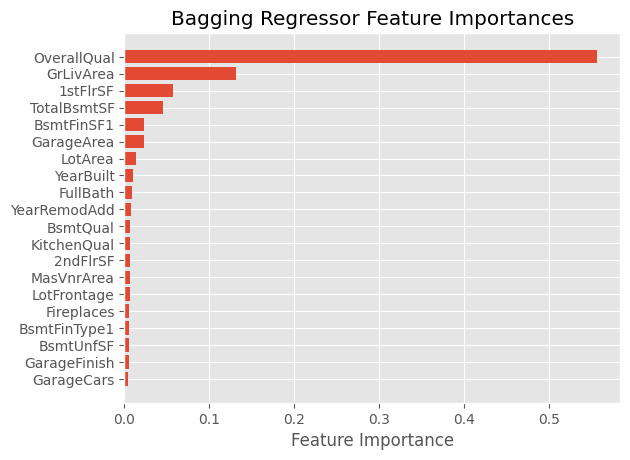

OverallQual: 0.5569
GrLivArea: 0.1320
1stFlrSF: 0.0569
TotalBsmtSF: 0.0452
BsmtFinSF1: 0.0235
GarageArea: 0.0232
LotArea: 0.0139
YearBuilt: 0.0098
FullBath: 0.0090
YearRemodAdd: 0.0075
BsmtQual: 0.0068
KitchenQual: 0.0067
2ndFlrSF: 0.0064
MasVnrArea: 0.0062
LotFrontage: 0.0060
Fireplaces: 0.0057
BsmtFinType1: 0.0050
BsmtUnfSF: 0.0050
GarageFinish: 0.0048
GarageCars: 0.0042
OpenPorchSF: 0.0039
ExterQual: 0.0036
MoSold: 0.0036
OverallCond: 0.0033
GarageYrBlt: 0.0032
WoodDeckSF: 0.0032
FireplaceQu: 0.0026
ScreenPorch: 0.0024
MSZoning_RM: 0.0024
BsmtFullBath: 0.0018
TotRmsAbvGrd: 0.0018
BsmtExposure: 0.0017
YrSold: 0.0014
CentralAir_Y: 0.0013
HeatingQC: 0.0012
BedroomAbvGr: 0.0010
Neighborhood_Crawfor: 0.0008
LotShape: 0.0008
HalfBath: 0.0008
MSZoning_RL: 0.0007
EnclosedPorch: 0.0006
BsmtCond: 0.0006
SaleCondition_Normal: 0.0006
GarageType_Detchd: 0.0006
ExterCond: 0.0006
Functional: 0.0006
Condition1_Norm: 0.0005
SaleType_WD : 0.0005
Foundation_PConc: 0.0005
SaleCondition_Family: 0.0005
M

In [36]:
#Bagging Feature Importances (bagging averages)
best_bagging = grid_search_bagging.best_estimator_
importances = np.mean(
    [tree.feature_importances_ for tree in best_bagging.estimators_],
    axis=0
)
#Pair with Feature Names
feature_importance = list(zip(X.columns, importances))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

#Plot Top 20 Feature Importances
top_features = feature_importance_sorted[:20]
names, values = zip(*top_features)
plt.barh(names, values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Bagging Regressor Feature Importances')
plt.show()

#Print all Importances
for name, importance in feature_importance_sorted:
    print(f"{name}: {importance:.4f}")